# RQ4: Does sentiment disagreement in window $t$ predict price instability in window $t+1$ 

## Import functions and libraries
- Helper function that is defined to load the data safely with predefined schema.
- Import needed libraries
- Helper function to apply a common style to all the plots

In [1]:
import sys

# Get the path to the helper functions
sys.path.append('../src/')

import importlib
import helper.data as data

# Reload helper functions
importlib.reload(data)

import polars as pl
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import seaborn as sns


def apply_common_style(title: str, xlabel: str = "Date", ylabel: str = ""):
    # General Style for Matplotlib
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.tight_layout()
    plt.show()

## Load Twitter and Reddit datasets and Exploratory Data Analysis
Load the pre-concatinated datasets for reddit and twitter that contain data from part 1 to part 4 for the training.

In [2]:
df_tweets = data.load_data_sentiment("../data/tweets_training.csv")
df_reddit = data.load_data_sentiment("../data/reddit_training.csv")

#### Prepare data
To prepare the data, we need to fix the datetime to data, and drop all unnecessary columns.

In [3]:
def prepare(df: pl.DataFrame):
    return (
        df.select(["timestamp", "sentiment_score"])
             .drop_nulls("sentiment_score")
             .with_columns(
                 pl.col("timestamp").dt.date().alias("date"),
                 pl.col("sentiment_score").alias("score"),
         )
    )

#### Exploratory Data Analysis on the sentiment for Twitter and Reddit
We can make some plots to show the raw sentiment data for both Twitter and Reddit as EDA:
- Basic stats
- Sentiment score distribution in KDE plot
- Daily Sentiment Mean in time series
- Sentiment score distirbution in box plot
- Relationship between Twitter and Reddit using scatter plot

In [4]:
def print_basic_stats(df_tweets, df_reddit):
    tw = prepare(df_tweets)
    rd = prepare(df_reddit)

    stats = pd.DataFrame({
        "Twitter": tw["score"].to_pandas().describe(),
        "Reddit": rd["score"].to_pandas().describe()
    })

    print("\n===== BASIC SENTIMENT STATISTICS =====\n")
    print(stats)
    print("\nDifference in means:", stats.loc["mean", "Twitter"] - stats.loc["mean", "Reddit"])

    tw_pd = tw.group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    rd_pd = rd.group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    
    # Merge dates for correlation
    merged = tw_pd.merge(rd_pd, on="date", suffixes=("_twitter", "_reddit"))
    
    corr = merged["mean_twitter"].corr(merged["mean_reddit"])
    print("\n===== DAILY CORRELATION =====")
    print(f"Correlation between Twitter and Reddit daily sentiment: {corr:.4f}")
print_basic_stats(df_tweets, df_reddit)


===== BASIC SENTIMENT STATISTICS =====

            Twitter         Reddit
count  1.029673e+06  694769.000000
mean   1.200417e-01      -0.140882
std    3.736773e-01       0.487843
min   -9.589081e-01      -0.958790
25%    6.103516e-04      -0.545090
50%    6.568909e-02      -0.164368
75%    2.654343e-01       0.157639
max    9.907913e-01       0.990305

Difference in means: 0.26092334689505714

===== DAILY CORRELATION =====
Correlation between Twitter and Reddit daily sentiment: 0.2722


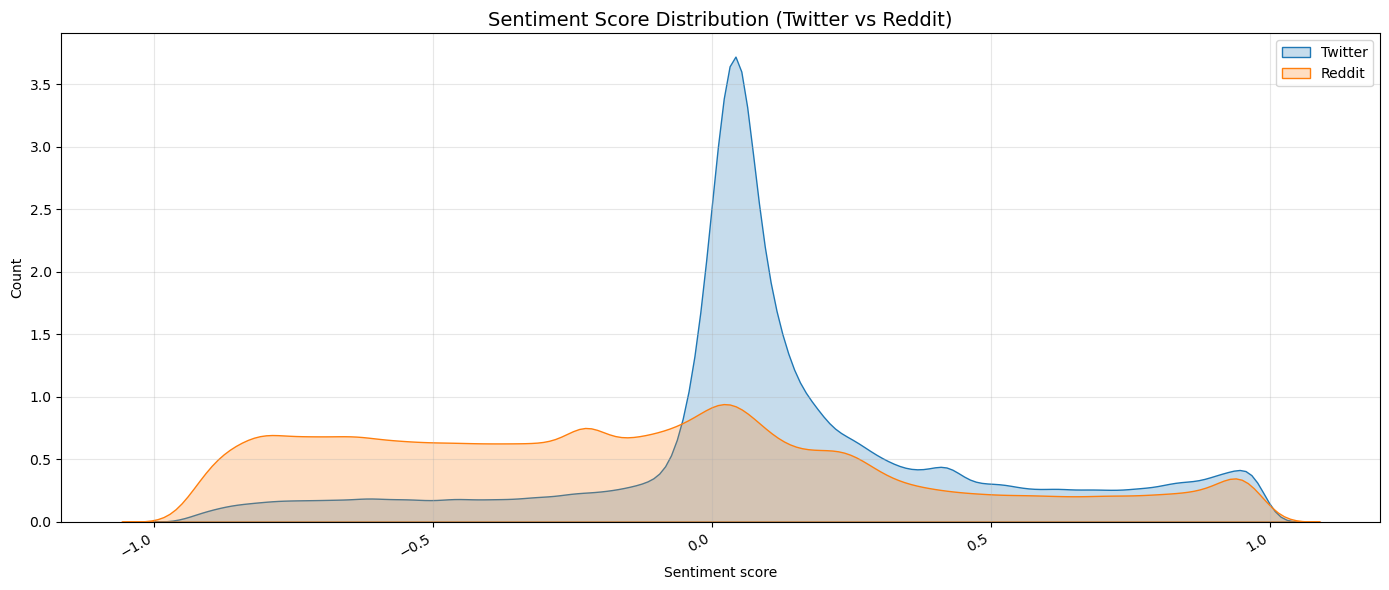

In [5]:
def plot_sentiment_distributions(df_tweets: pl.DataFrame, df_reddit: pl.DataFrame):
    """Basic plots for raw tweets & reddit sentiment."""
    tw_pd = prepare(df_tweets).to_pandas()
    rd_pd = prepare(df_reddit).to_pandas()
    plt.figure(figsize=(14, 6))
    sns.kdeplot(tw_pd["score"], fill=True, label="Twitter")
    sns.kdeplot(rd_pd["score"], fill=True, label="Reddit")
    
    apply_common_style(
        "Sentiment Score Distribution (Twitter vs Reddit)",
        xlabel="Sentiment score",
        ylabel="Count",
    )
    
plot_sentiment_distributions(df_tweets, df_reddit)

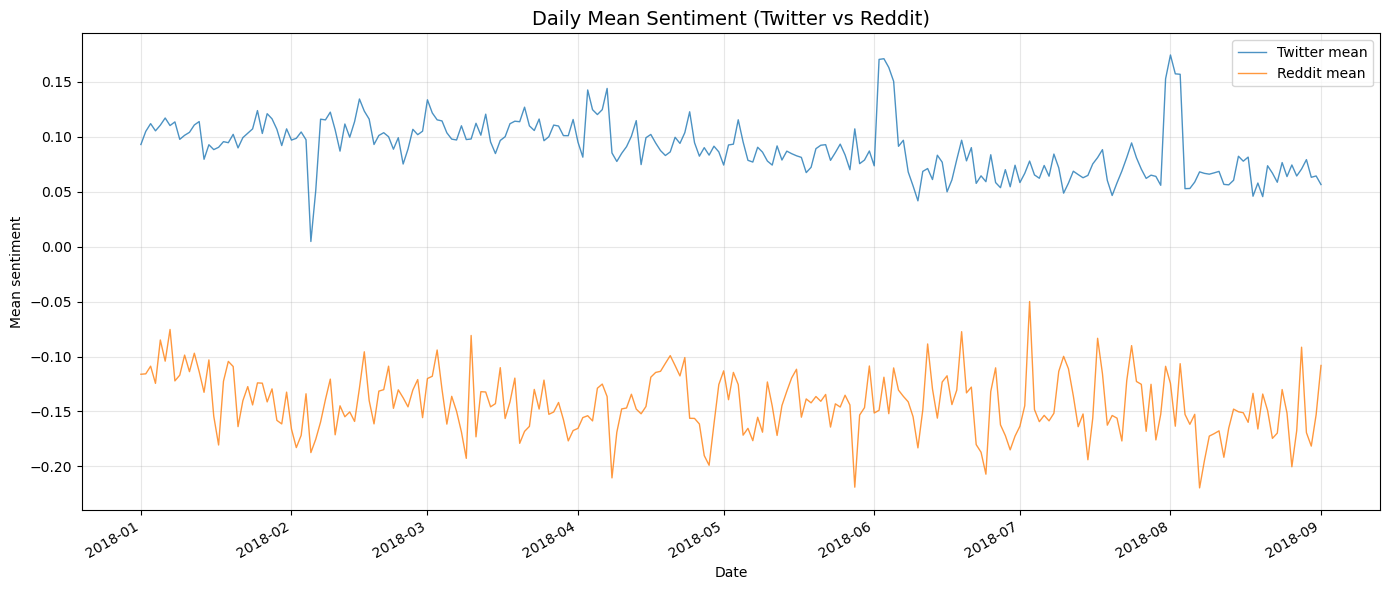

In [6]:
def plot_daily_means(df_tweets: pl.DataFrame, df_reddit: pl.DataFrame):
    tw_pd = prepare(df_tweets).group_by("date").agg(pl.col("score").mean().alias("mean_score")).sort("date").to_pandas()
    rd_pd = prepare(df_reddit).group_by("date").agg(pl.col("score").mean().alias("mean_score")).sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(tw_pd["date"], tw_pd["mean_score"], linewidth=1, alpha=0.8, label="Twitter mean")
    plt.plot(rd_pd["date"], rd_pd["mean_score"], linewidth=1, alpha=0.8, label="Reddit mean")

    apply_common_style(
        "Daily Mean Sentiment (Twitter vs Reddit)",
        xlabel="Date",
        ylabel="Mean sentiment",
    )
plot_daily_means(df_tweets, df_reddit)

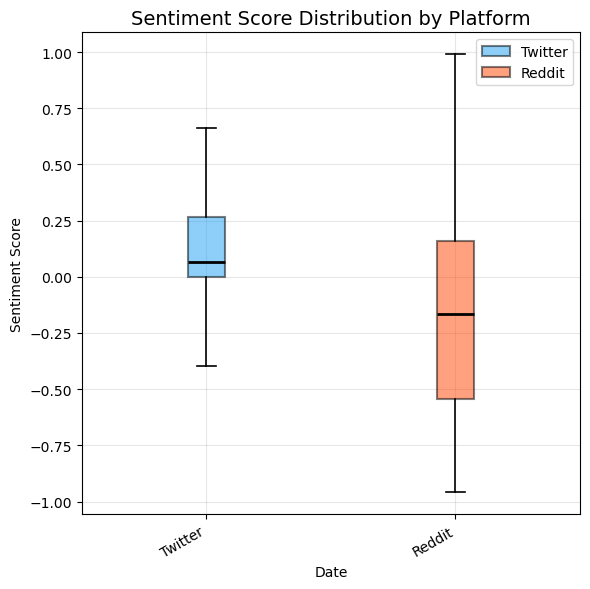

In [7]:
def plot_boxplots(df_tweets, df_reddit):
    tw = prepare(df_tweets).to_pandas()["score"]
    rd = prepare(df_reddit).to_pandas()["score"]

    data = [tw, rd]

    plt.figure(figsize=(6, 6))

    # Create boxplot
    bp = plt.boxplot(
        data,
        tick_labels=["Twitter", "Reddit"],
        patch_artist=True,
        showfliers=False,     # Hide extreme outliers for clarity
        boxprops=dict(linewidth=1.5),
        medianprops=dict(color="black", linewidth=2),
        whiskerprops=dict(linewidth=1.2),
        capprops=dict(linewidth=1.2),
        label=["Twitter", "Reddit"]
    )

    # Color the boxes
    colors = ["#1DA1F2", "#FF4500"]  # Twitter blue, Reddit orange
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

    apply_common_style(
        "Sentiment Score Distribution by Platform",
        xlabel="Date",
        ylabel="Sentiment Score",
    )
plot_boxplots(df_tweets, df_reddit)

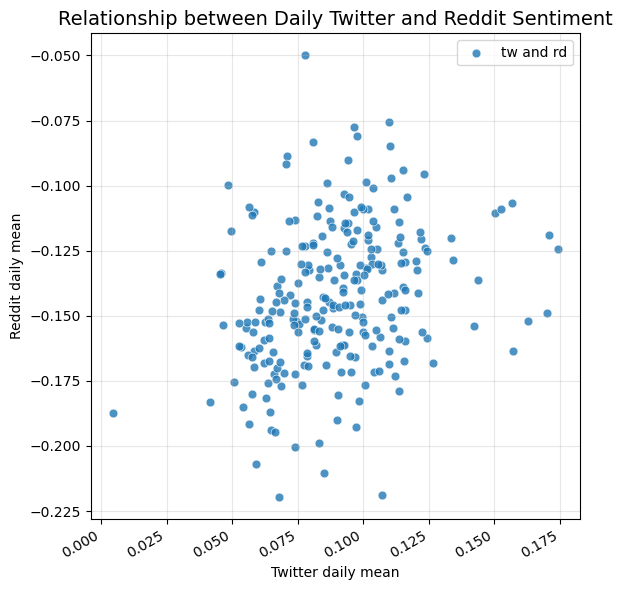

In [8]:
def plot_scatter(df_tweets, df_reddit):
    tw_pd = prepare(df_tweets).group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    rd_pd = prepare(df_reddit).group_by("date").agg(pl.col("score").mean().alias("mean")).sort("date").to_pandas()
    
    # Merge dates 
    merged = tw_pd.merge(rd_pd, on="date", suffixes=("_twitter", "_reddit"))

    # Scatter plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=merged, x="mean_twitter", y="mean_reddit", s=40, alpha=0.8,label="tw and rd")
    apply_common_style(
        "Relationship between Daily Twitter and Reddit Sentiment",
        xlabel="Twitter daily mean",
        ylabel="Reddit daily mean",
    )

plot_scatter(df_tweets, df_reddit)


#### Conclusion from EDA

Based on the EDA, we can draw the following conclusions:
- **Overall sentiment levels are very different between platforms**
    -  Twitter tends to lean **positive** on average, with **mean sentiment of +0.12**
    -  Reddit tends to lean **negative** on average, with **mean sentiment of -0.14**
    -  The **difference** is around **0.26**, visible in KDE and boxplots, Twitter’s distribution is skewed toward positive values, while Reddit’s is more spread out and shifted to the negative side.
- **Sentiment variability is higher on Reddit**
    - Twitter: 0.374
    - Reddit: 0.488
    - Reddit exhibits **more emotional variability**.
    - Indicate that Reddit are **more polarized and expressive**, while Twitter is more **concentrated near neutral or mildly positive**.
- **Daily sentiment trends are stable yet distinct between platforms**
    - Twitter shows a stable positive trend with **small fluctuations**.
    - Reddit consistently trends negative with **greater volatility**.
    - There is **no major sentiment shift on either platform**.
    - Both behave independently with their own typical emotional “baseline”.
- **Relationship between platforms is weak but positive**
    - The **daily correlation ≈ 0.27**.
    - **Weak positive relationship**: when Twitter sentiment rises, Reddit sentiment tends to rise slightly as well.
    - However, the large scatter in the points shows that **the platforms do not move together tightly**.
    - Both platforms respond somewhat to shared news cycles or real-world events,
    - But their userbases express emotions **quite differently**, so daily sentiment movements remain largely independent.
- **Distribution shape differences reflect community culture**
    - **Twitter** is dominated by neutral or slightly positive short posts → tighter distribution around 0–0.2.
    - **Reddit** content is longer, more opinionated, and often critical → broader distribution and negative central tendency.

Therefore in short: 
- **Twitter**
    - More positive overall
    - Less variable
    - Sentiment tightly clustered around neutral-positive
    - Stable day-to-day patterns
- **Reddit**
    - More negative overall
    - More variable and expressive
    - Broader distribution with stronger negative skew
    - Higher day-to-day fluctuation
- **Cross-platform relationship**
    - Weak positive correlation (~0.27)
    - Some shared patterns, but major differences in tone and emotional expression

## Analysis Frequency

For the window of the data, we choose to have the frequency to be **Daily**, and let each window be indexed by $t$. For each window $t$:
- Aggregate sentiment disagreement using sentiment score or label with timestamp in window $t$
- Compute price instability for the next window $t+1$. 

## Sentiment Disagreement

Let $s_{i, t}$ be the sentiment score of the text $i$ in the window $t$. Where $i=1...N_t$, and $N_t$ is the total number of text in the window $t$. We multiple sentiment features:
- $D^{\text{MAD}}_t$: **Median Absolute Deviation** (MAD) [1], this is the continuous score dispersion based on the median. Defined as:
$$D^{\text{MAD}}_t = \text{median} \Big(|s_{i, t}-\text{median}(s_{i, t})|\Big)$$
- $D^{\Delta \mu}_t$: **Mean Gap** fot the cross-platform disagreement between Twitter and Reddit. First compute the mean sentiment per platform $\mu_{t}^{tw}$ and $\mu_{t}^{rd}$. Then the mean gap between the platform is defined as:
$$D^{\Delta \mu}_t= \bigg|\mu_{t}^{tw} - \mu_{t}^{rd}\bigg|$$
- $D_t^{\text{var}}$: **Variance** defined as:
$$D_t^{\text{var}}=\text{Var}(s_{i, t})$$
- $D_t^{\text{std}}$: **Standard Deviation** defined as:
$$D_t^{\text{std}}=\sqrt{\text{Var}(s_{i, t})}$$
- $D_t^{\text{IQR}}$: **Interquartile Range** is as robust volatility proxy, capturing the typical variation while ignoring extremes. Defined as:
$$D_t^{\text{IQR}}=Q_{0.75}(s_{i,t})-Q_{0.25}(s_{i,t})$$
- $D_t^{(7\text{d})}$: 7 Day rolling disagreement factor for all disagreement measure, defined as:
$$D_t^{(7\text{d})}=\frac{1}{7}\sum^t_{r=t-6}D_r$$

In [9]:
def daily_stats(df: pl.DataFrame, prefix: str) -> pl.DataFrame:
    """
    Return per-day stats for one platform.
    Output columns:
      ['date', 'reddit_mean', 'reddit_median', 'reddit_mad', 'reddit_var',
       'reddit_std', 'reddit_iqr', 'reddit_n']
    """
    base = df.select(["date", "score"]).drop_nulls(["score"])

    df2 = base.with_columns(pl.col("score").median().over("date").alias("med"))
    df2 = df2.with_columns((pl.col("score") - pl.col("med")).abs().alias("abs_dev"))

    q75 = pl.col("score").quantile(0.75, interpolation="nearest")
    q25 = pl.col("score").quantile(0.25, interpolation="nearest")

    return (
        df2.group_by("date")
           .agg([
               pl.col("score").mean().alias(f"{prefix}mean"),
               pl.col("score").median().alias(f"{prefix}median"),
               pl.col("abs_dev").median().alias(f"{prefix}mad"),
               pl.col("score").var().alias(f"{prefix}var"),
               pl.col("score").std().alias(f"{prefix}std"),
               (q75 - q25).alias(f"{prefix}iqr"),
               pl.len().alias(f"{prefix}n"),
           ])
           .sort("date")
    )

def mean_gap(tw: pl.DataFrame, rd: pl.DataFrame) -> pl.DataFrame:
    """
    Compute and return Twitter–Reddit mean gap:
      D_gap = |twitter_mean - reddit_mean|
    Keeps all columns from both stats tables (outer join on date).
    """
    return (tw.join(rd, on="date", how="full")
              .with_columns((pl.col("twitter_mean") - pl.col("reddit_mean")).abs().alias("D_gap"))
              .sort("date")
    )
    
def dispersion_all(tw: pl.DataFrame, rd: pl.DataFrame) -> pl.DataFrame:
    """
    Disagreement across ALL posts (Twitter + Reddit) per day:
      - D_mad, D_var, D_std, D_iqr
      - all_mean, all_n
    """
    all_scores = pl.concat(
        [tw.select(["date", "score"]), rd.select(["date", "score"])],
        how="vertical"
    ).drop_nulls(["score"])

    df2 = all_scores.with_columns(pl.col("score").median().over("date").alias("med"))
    df2 = df2.with_columns((pl.col("score") - pl.col("med")).abs().alias("abs_dev"))

    q75 = pl.col("score").quantile(0.75, interpolation="nearest")
    q25 = pl.col("score").quantile(0.25, interpolation="nearest")

    return (
        df2.group_by("date")
           .agg([
               pl.col("abs_dev").median().alias("D_mad"),
               pl.col("score").var().alias("D_var"),
               pl.col("score").std().alias("D_std"),
               (q75 - q25).alias("D_iqr"),
               pl.col("score").mean().alias("all_mean"),
               pl.len().alias("all_n"),
           ])
           .sort("date")
    )

def add_weekly_rolling_disagreement(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add 7-day rolling disagreement features:
      D_mad_7d, D_var_7d, D_std_7d, D_iqr_7d, D_gap_7d
    using a rolling mean over the last 7 days (including today).
    """
    df = df.sort("date")

    disagreement_cols = ["D_mad", "D_var", "D_std", "D_iqr", "D_gap"]

    return df.with_columns(
        [
            pl.col(col)
              .rolling_mean(window_size=7, min_samples=1)
              .alias(f"{col}_7d")
            for col in disagreement_cols
        ]
    )

def sentiment_disagreement_daily(reddit_df: pl.DataFrame, tweets_df: pl.DataFrame) -> pl.DataFrame:
    """
    Returns per-day sentiment features including:
      - Platform stats (mean/median/mad/var/std/iqr/n)
      - D_gap (abs mean gap)
      - All-post dispersion: D_mad, D_var, D_std, D_iqr
    """

    rd = prepare(reddit_df)
    tw = prepare(tweets_df)

    rd_stats = daily_stats(rd, "reddit_")
    tw_stats = daily_stats(tw, "twitter_")

    # Twitter-Reddit mean gap (absolute)
    gap_df = mean_gap(tw=tw_stats, rd=rd_stats)

    # Combined MAD and Disagreement across ALL posts (Twitter + Reddit)
    disp_df = dispersion_all(tw=tw, rd=rd)

    temp = gap_df.join(disp_df, on="date", how="left").sort("date")
    return add_weekly_rolling_disagreement(temp)

Based on these function we can generate a sentiment training dataset

In [10]:
sent_train = sentiment_disagreement_daily(df_tweets, df_reddit)
print(sent_train.columns)

['date', 'twitter_mean', 'twitter_median', 'twitter_mad', 'twitter_var', 'twitter_std', 'twitter_iqr', 'twitter_n', 'date_right', 'reddit_mean', 'reddit_median', 'reddit_mad', 'reddit_var', 'reddit_std', 'reddit_iqr', 'reddit_n', 'D_gap', 'D_mad', 'D_var', 'D_std', 'D_iqr', 'all_mean', 'all_n', 'D_mad_7d', 'D_var_7d', 'D_std_7d', 'D_iqr_7d', 'D_gap_7d']


### Plot Daily Sentiment Disagreement
Function that plot daily sentiment disagreement with all the features: $D^{\text{MAD}}_t$, $D^{\Delta\mu}_t$, $D^{\text{var}}_t$, $D^{\text{std}}_t$, and $D^{\text{iqr}}_t$

In [11]:
def plot_daily_sentiment_disagreement(sent_daily: pl.DataFrame):
    """
    Plots D_mad, D_gap, D_var, D_std, D_iqr over time
    """
    df = sent_daily.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["D_mad"], linewidth=1, alpha=0.8, label="D_mad")
    plt.plot(df["date"], df["D_gap"], linewidth=1, alpha=0.8, label="D_gap")
    plt.plot(df["date"], df["D_var"], linewidth=1, alpha=0.8, label="D_var")
    plt.plot(df["date"], df["D_std"], linewidth=1, alpha=0.8, label="D_std")
    plt.plot(df["date"], df["D_iqr"], linewidth=1, alpha=0.8, label="D_iqr")

    apply_common_style(
        "Daily Sentiment Disagreement (D_mad, D_gap, D_var, D_std, D_iqr)",
        xlabel="Date",
        ylabel="Value",
    )
    
def plot_7d_sentiment_disagreement(sent_daily: pl.DataFrame):
    """
    Plots D_mad, D_gap, D_var, D_std, D_iqr over time
    """
    df = sent_daily.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["D_mad_7d"], linewidth=1, alpha=0.8, label="D_mad_7d")
    plt.plot(df["date"], df["D_gap_7d"], linewidth=1, alpha=0.8, label="D_gap_7d")
    plt.plot(df["date"], df["D_var_7d"], linewidth=1, alpha=0.8, label="D_var_7d")
    plt.plot(df["date"], df["D_std_7d"], linewidth=1, alpha=0.8, label="D_std_7d")
    plt.plot(df["date"], df["D_iqr_7d"], linewidth=1, alpha=0.8, label="D_iqr_7d")

    apply_common_style(
        "7 Day Rolling Sentiment Disagreement (D_mad_7d, D_gap_7d, D_var_7d, D_std_7d, D_iqr_7d)",
        xlabel="Date",
        ylabel="Value",
    )

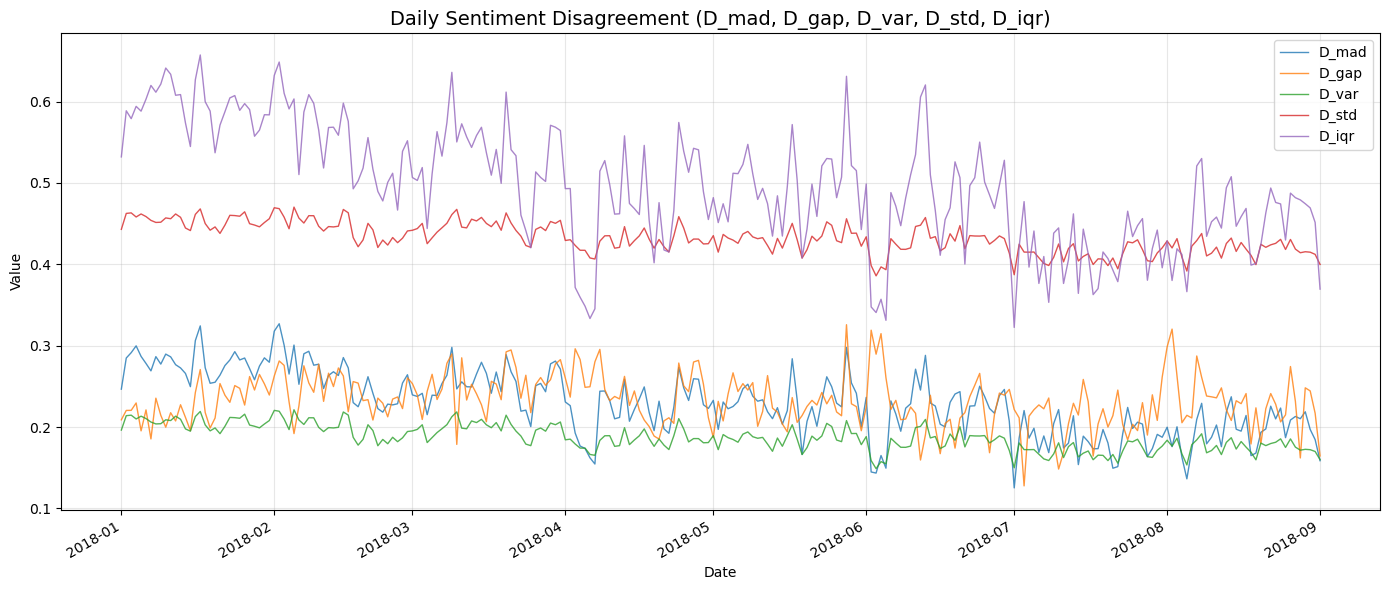

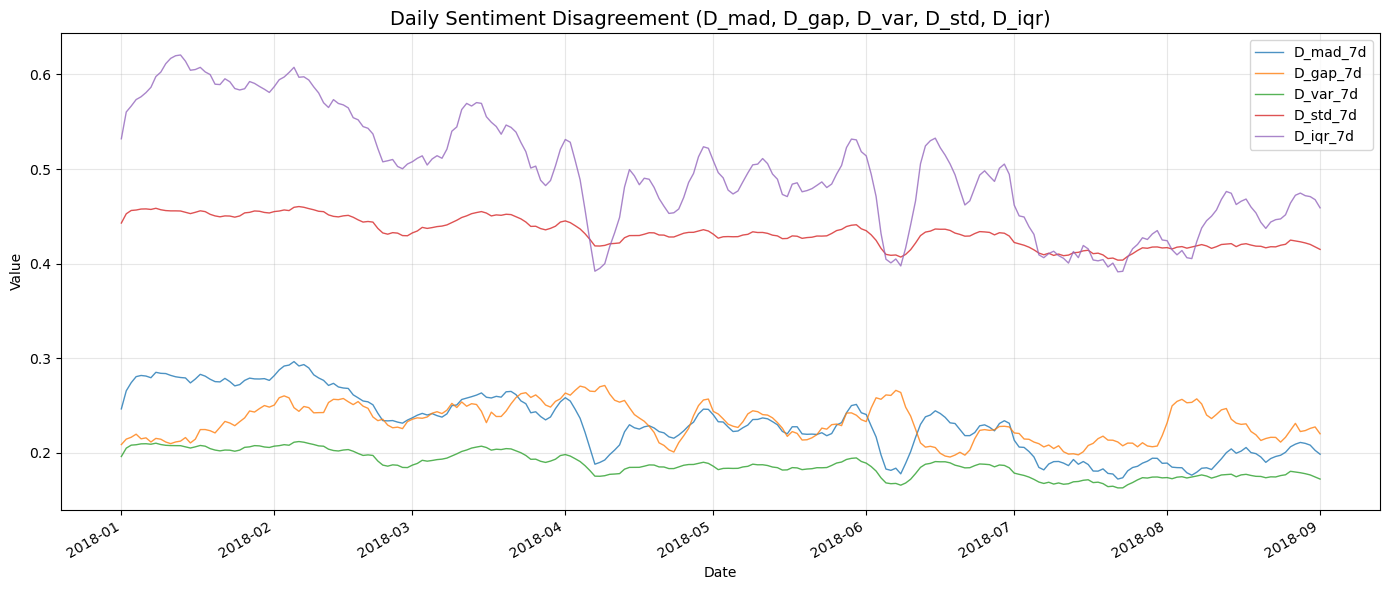

In [12]:
plot_daily_sentiment_disagreement(sent_train)   
plot_7d_sentiment_disagreement(sent_train)   

In [46]:
def plot_disagreement_normalized(sent_daily: pl.DataFrame):
    df = sent_daily.sort("date").to_pandas()
    # features = ["D_mad", "D_gap", "D_var", "D_std", "D_iqr"]
    features = ["D_mad_7d", "D_gap_7d", "D_var_7d", "D_std_7d", "D_iqr_7d"]
    normalized = (df[features] - df[features].mean()) / df[features].std()

    plt.figure(figsize=(14, 6))
    for f in features:
        plt.plot(df["date"], normalized[f], label=f, alpha=0.8)

    apply_common_style(
        "Normalized Daily Sentiment Disagreement (Z-scores)",
        xlabel="Date",
        ylabel="Normalized Value"
    )


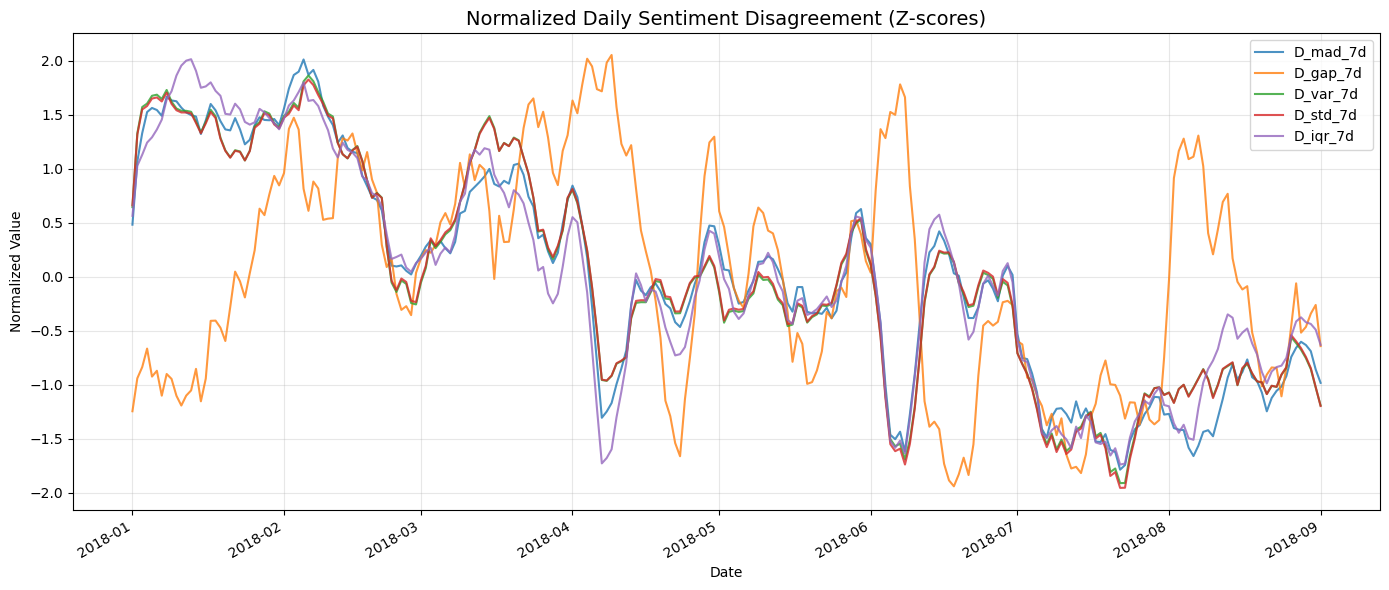

In [47]:
plot_disagreement_normalized(sent_train)   

## Load BTC data and plot raw data
We can load the btc that already contain part 1 to 4 and plot the raw btc close price with 1m interval

In [17]:
df_btc = data.load_btc("../data/btc_training.csv")

### Plot raw BTC data

In [18]:
def plot_raw_btc_1m(df_btc: pl.DataFrame, ts_col="timestamp", close_col="close", vol_col="volume"):
    """Basic plots for raw 1m BTC: close price + volume."""
    btc = (
        df_btc.select([ts_col, close_col, vol_col])
              .drop_nulls(close_col)
              .sort(ts_col)
    )

    btc_pd = btc.to_pandas()

    # Price
    plt.figure(figsize=(14, 6))
    plt.plot(btc_pd[ts_col], btc_pd[close_col], linewidth=1, alpha=0.8, label="BTC Close Price")
    apply_common_style("BTC 1-Minute Close Price", xlabel="Date", ylabel="Price (USD)")

    # Volume
    plt.figure(figsize=(14, 6))
    plt.plot(btc_pd[ts_col], btc_pd[vol_col], linewidth=1, alpha=0.8, label="BTC Volume")
    apply_common_style("BTC 1-Minute Volume", xlabel="Date", ylabel="Volume")

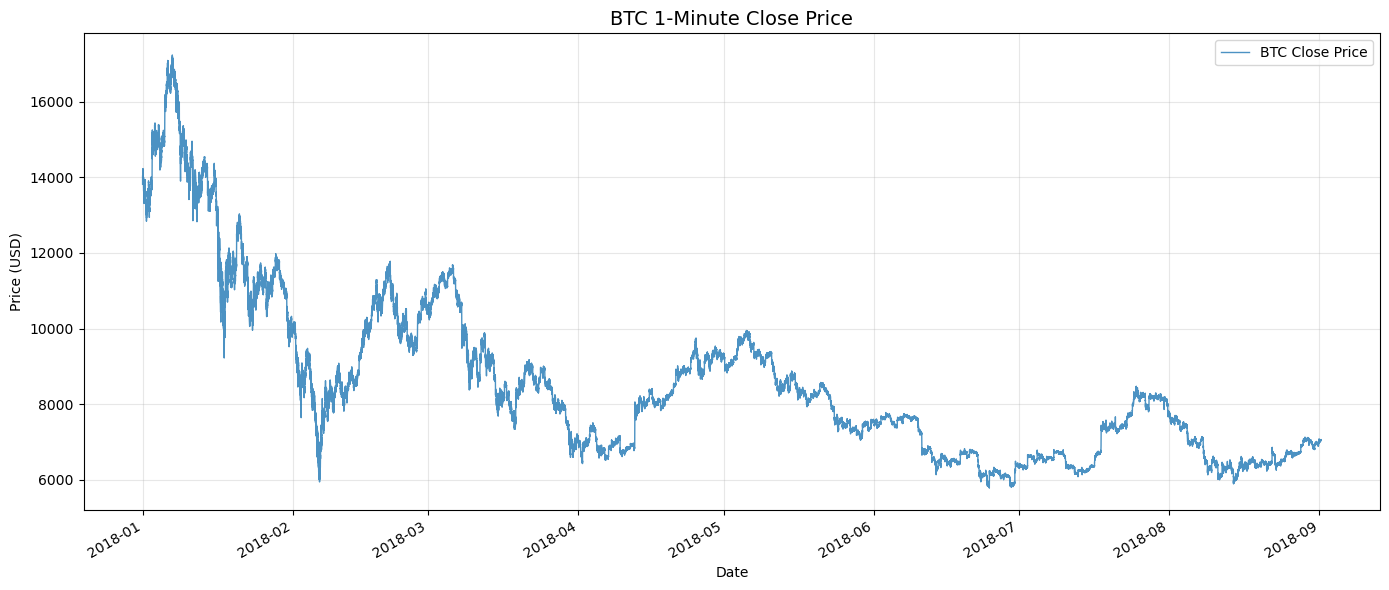

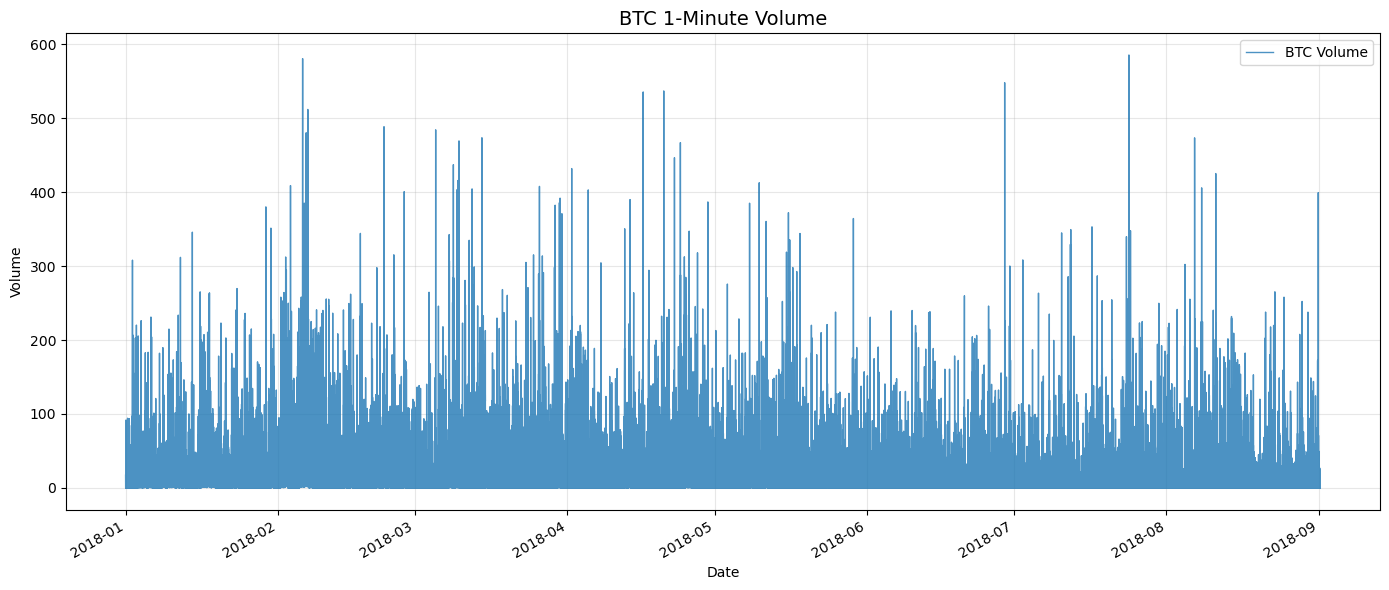

In [19]:
plot_raw_btc_1m(df_btc)

## Compute Price Instability

Let $r_t$ be the close-to-close log return, the measure of relative price change from one window to the next window using logarithmic scale. Defined using close price $C$: 
$$r_t=\log\left(\frac{C_t}{C_{t-1}}\right)$$ 

All possible features are:
- **Realized Volatility (RV)**: A volatility measure computed from intraday data, it captures the total price varaition that occurred within the day. Using $r_t$ we can define the realized volatility: 
$$RV_t=\sqrt{\sum_{i\in t}r_i^2}$$
- **Parkinson Volatility**: A range-based daily volatility estimator that only uses the high and low prices, it reflect how wide the price range was during the day. Using high $H_t$ and low $L_t$, we define:
$$\sigma_t^{\text{Parkinson}}=\sqrt{\frac{1}{4\ln 2}\left(\ln \frac{H_t}{L_t}\right)^2}$$
- **Absolute Daily Log Return**: The absolute value of the close-to-close daily log return, measures the magnitude of the day's price change ignoring the direction. Defined with:
$$\text{absret\_daily}=|\ln (C_t)-\ln (C_{t-1})|$$

In [20]:
def btc_daily_instability_from_1m(
    btc_df: pl.DataFrame,
    ts_col: str = "timestamp",
    require_full_day: bool = True,
    full_day_bars: int = 1440,  
) -> pl.DataFrame:
    """
    Computes daily price instability from 1-minute OHLCV:
      - rv: realized volatility = sqrt(sum intraday log-return^2)
      - parkinson: range-based daily estimator using daily high/low
      - absret_daily: abs(close-to-close daily log return)

    If require_full_day=True, keeps only days with exactly 1440 bars.
    """

    btc = (btc_df.with_columns(pl.col(ts_col).dt.date().alias("date")).sort(ts_col))

    # Intraday log returns within each day (order matters)
    btc = btc.with_columns(pl.col("close").log().alias("log_close"))
    btc = btc.with_columns(
        (pl.col("log_close") - pl.col("log_close").shift(1).over("date")).alias("logret_intra")
    )
    
    btc = btc.with_columns(pl.col("logret_intra").fill_null(0.0).pow(2).alias("logret2"))
    LN2 = float(math.log(2.0))
    SQRT_365 = float(math.sqrt(365.0))
    daily = (
        btc.group_by("date")
           .agg([
               pl.len().alias("n_bars"),
               pl.col("open").sort_by(ts_col).first().alias("open_d"),
               pl.col("high").max().alias("high_d"),
               pl.col("low").min().alias("low_d"),
               pl.col("close").sort_by(ts_col).last().alias("close_d"),
               pl.col("volume").sum().alias("volume_d"),
               pl.col("logret2").sum().alias("rv_var"),
               pl.col("logret_intra").is_not_null().sum().alias("n_returns"),
           ])
           .sort("date")
           .with_columns([
               pl.col("rv_var").sqrt().alias("rv"),
               ((pl.col("high_d") / pl.col("low_d")).log().pow(2) / (4.0 * LN2)).sqrt().alias("parkinson"),
           ])
    )

    # daily close-to-close log return + abs return
    daily = daily.with_columns([
        (pl.col("close_d").log() - pl.col("close_d").log().shift(1)).alias("logret_daily"),
        (pl.col("close_d").log() - pl.col("close_d").log().shift(1)).abs().alias("absret_daily"),
    ])

    if require_full_day:
        daily = daily.filter(pl.col("n_bars") == full_day_bars)

    return daily

With this code we can generate the training dataset for the BTC

In [21]:
btc_train  = btc_daily_instability_from_1m(df_btc, require_full_day=True)

### Plot BTC Daily Instability
This function plot Realized volatility, Parkinson, and Absolute daily log return

In [22]:
def plot_btc_daily_instability(btc_daily: pl.DataFrame):
    """Plots daily rv, parkinson, and absret_daily with unified style."""
    df = btc_daily.sort("date").to_pandas()

    # Realized volatility
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["rv"], linewidth=1, alpha=0.8, label="BTC RV")
    apply_common_style("Daily Realized Volatility (rv)", xlabel="Date", ylabel="rv")

    # Parkinson
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["parkinson"], linewidth=1, alpha=0.8, label="BTC Parkinson")
    apply_common_style("Daily Parkinson Volatility", xlabel="Date", ylabel="Parkinson")

    # Absolute daily return
    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["absret_daily"], linewidth=1, alpha=0.8, label="BTC absret")
    apply_common_style("Daily Absolute Close-to-Close Log Return", xlabel="Date", ylabel="|logret|")


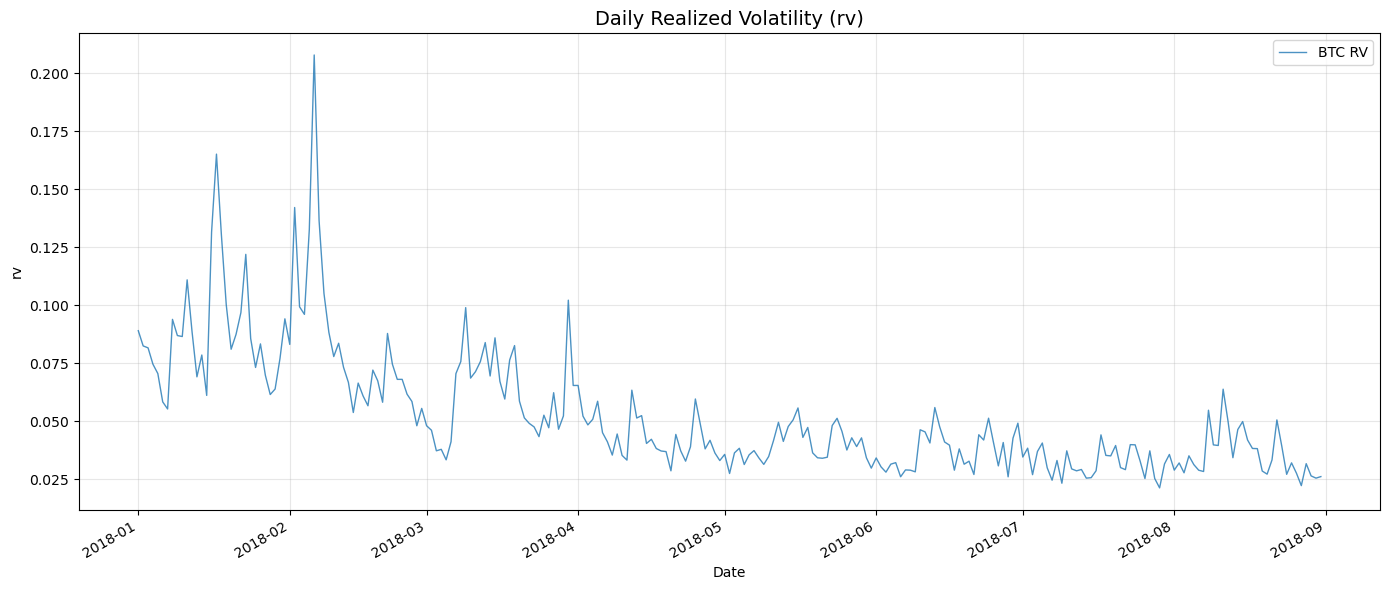

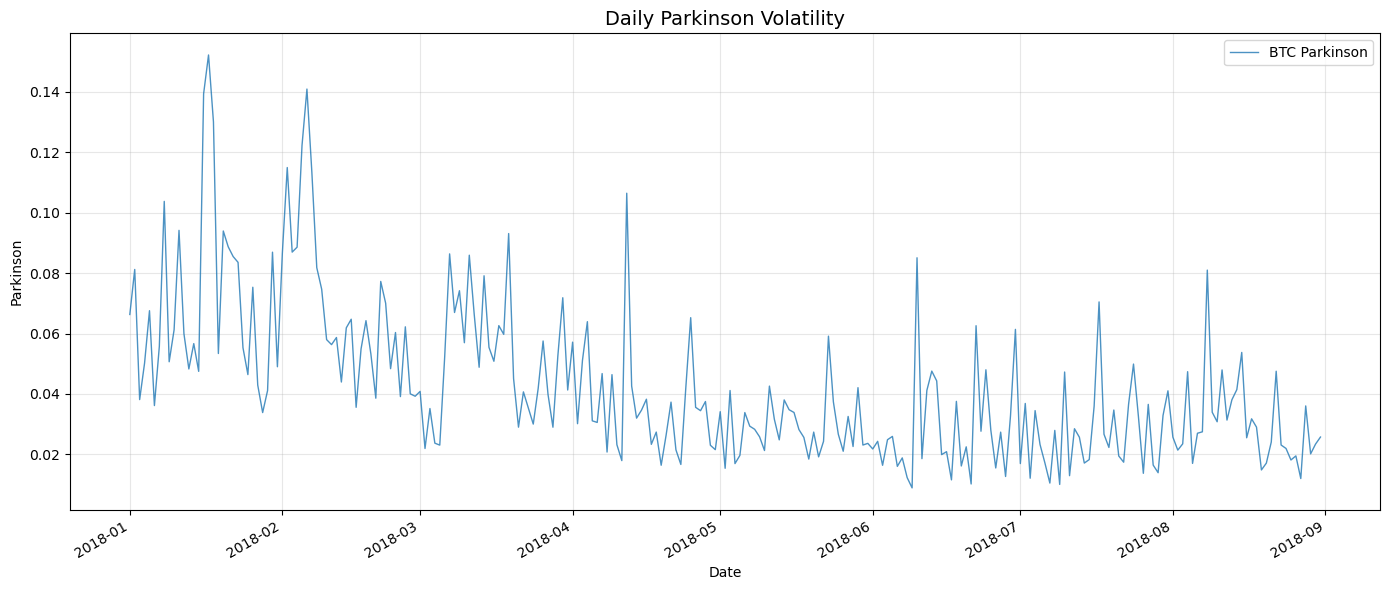

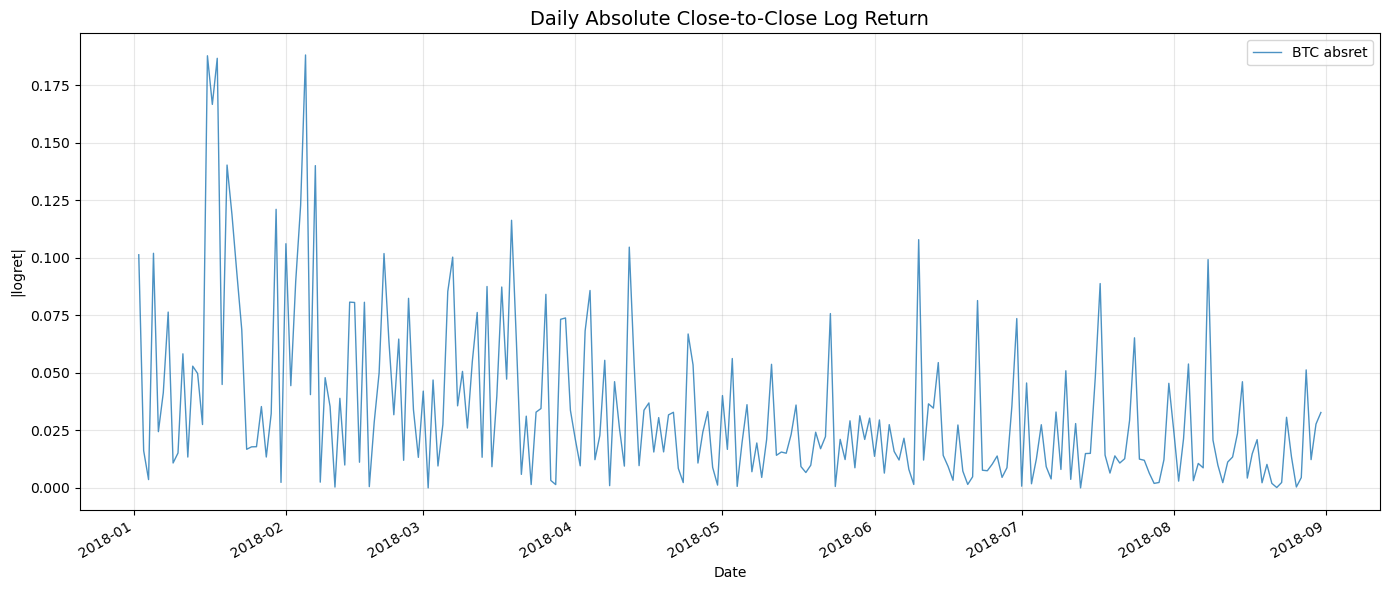

In [23]:
plot_btc_daily_instability(btc_train)

## Combine Sentiment Disagreement with Price Instability to build a model
We try to predict the future using only inforation that would have been know at the time, therefore we shift the values by one day to create lagged values:
- Lagged Daily MAD
- Lagged Daily Mean Gap
- Lagged Daily RV

This represent the question:
> Given everything I knew up to the end of day $t-1$, can I predict volatility on day $t$

The training target we can choose between **Realized Volatility**, **Parkinson Volatility**, and **Absolute Daily Log Return**. For example if we choose RV as out target, this means the learning objective is: 
> Given yesterday's sentiment and volatility, predict today's realized volatility

In [24]:
def build_daily_model_df(
    btc_daily: pl.DataFrame,
    sent_daily: pl.DataFrame,
    target_col: str = "rv",   # rv, parkinson, absret_daily
) -> pl.DataFrame:
    """
    Produces modeling table where day t target uses disagreement from day t-1:
      y_t = target(t)
      X_t includes D_mad(t-1), D_gap(t-1), D_var(t-1), D_std(t-1), D_iqr(t-1), rv(t-1)
    """
    df = (
        btc_daily.join(sent_daily, on="date", how="left")
                 .sort("date")
                 .with_columns([
                     pl.col("D_mad").shift(1).alias("D_mad_lag1"),
                     pl.col("D_gap").shift(1).alias("D_gap_lag1"),
                     pl.col("D_var").shift(1).alias("D_var_lag1"),
                     pl.col("D_std").shift(1).alias("D_std_lag1"),
                     pl.col("D_iqr").shift(1).alias("D_iqr_lag1"),
                     pl.col(target_col).shift(1).alias(f"{target_col}_lag1"),
                 ])
                 .with_columns(pl.col(target_col).alias("y"))
                 .drop_nulls(subset=["y", "D_mad_lag1", "D_gap_lag1", f"{target_col}_lag1"])
    )
    return df

Using this function we can generate model that we use to train, based on the traget between rv, parkinson, absret_daily

In [25]:
model_train_rv = build_daily_model_df(btc_train, sent_train, target_col="rv")
model_train_park = build_daily_model_df(btc_train, sent_train, target_col="parkinson")
model_train_asbret = build_daily_model_df(btc_train, sent_train, target_col="absret_daily")

### Plot the target timeseries
We can plot the timeseries for the target to compare whether the model is generate corretly, if the rv is correctly lagged, then the shifted RV will be exactly shifted to the right by one

In [26]:
def plot_model_target_timeseries(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Plots y_t and target_lag1 over time.
    base_target is the original target_col used in build_daily_model_df
    (e.g. "rv" or "parkinson").
    """
    df = model_train.sort("date").to_pandas()

    plt.figure(figsize=(14, 6))
    plt.plot(df["date"], df["y"], linewidth=1, alpha=0.8, label="y (target today)")
    lag_col = f"{base_target}_lag1"
    if lag_col in df.columns:
        plt.plot(df["date"], df[lag_col], linewidth=1, alpha=0.8, label=f"{lag_col}")

    apply_common_style(
        title=f"Daily Target and Lagged Target ({base_target})",
        xlabel="Date",
        ylabel=base_target,
    )

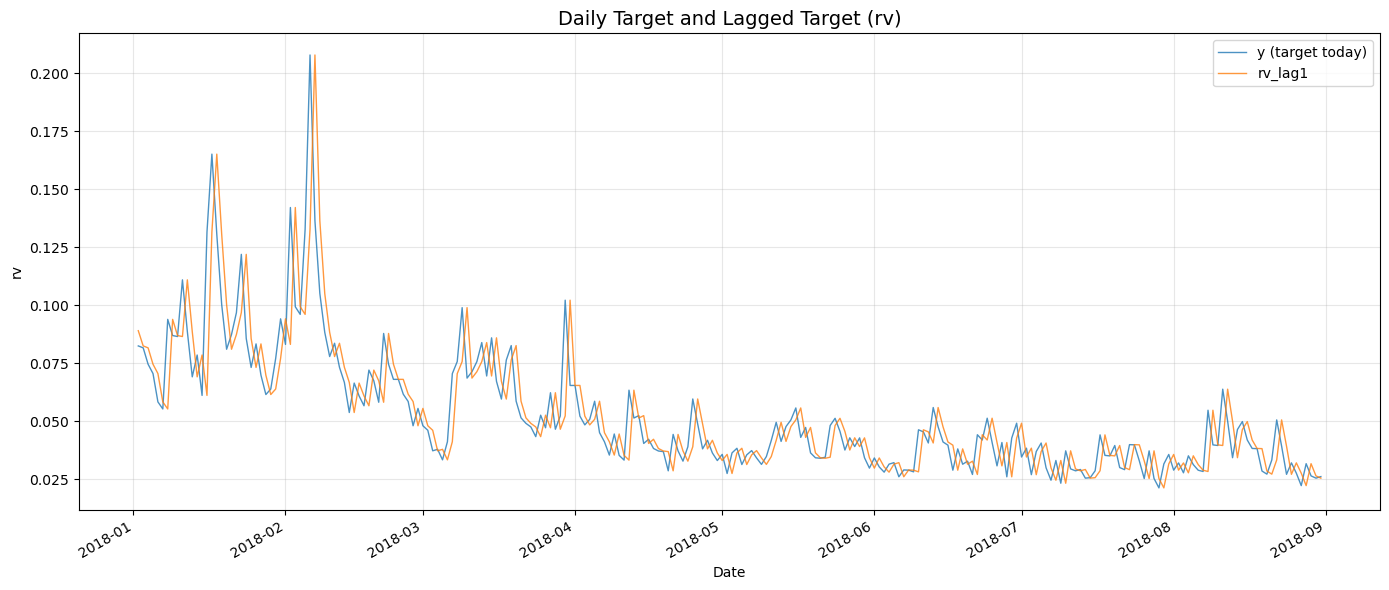

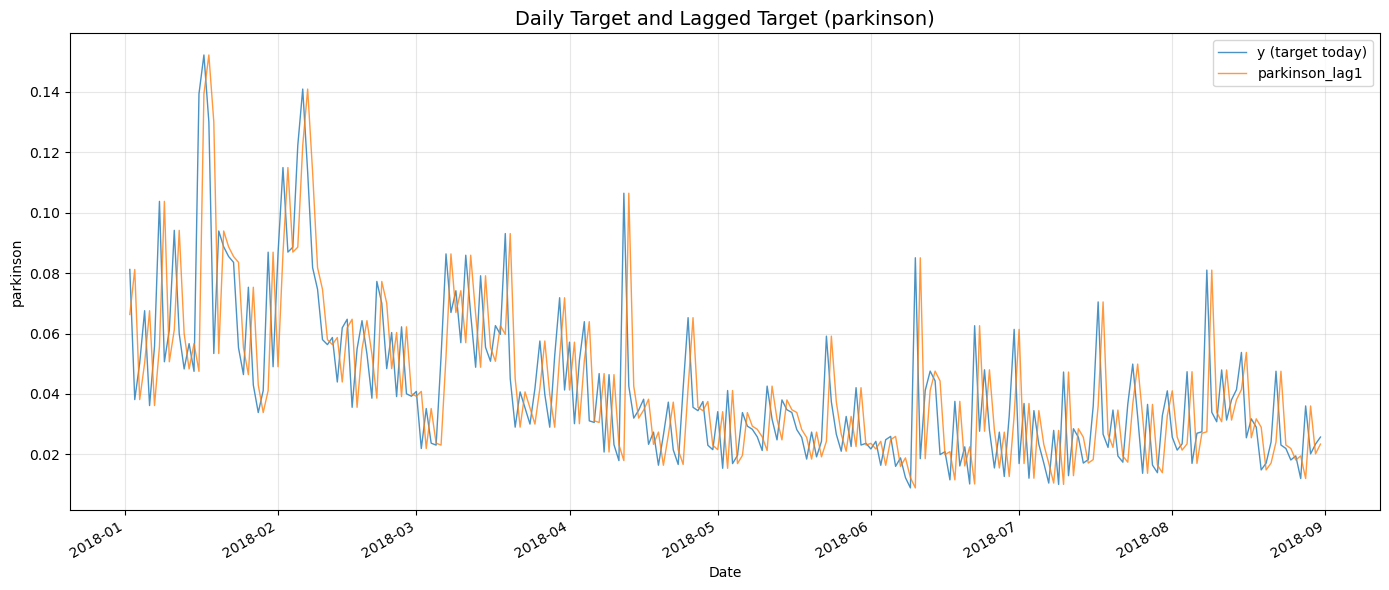

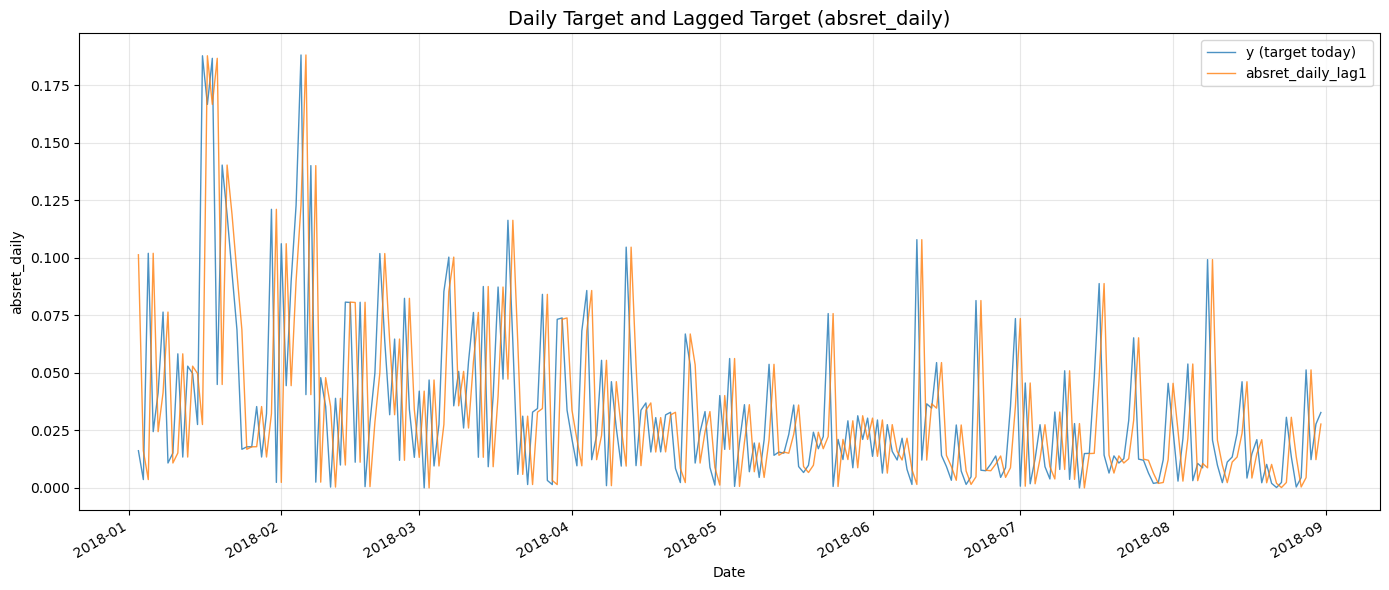

In [27]:
plot_model_target_timeseries(model_train_rv, base_target="rv")
plot_model_target_timeseries(model_train_park, base_target="parkinson") 
plot_model_target_timeseries(model_train_asbret, base_target="absret_daily")

### Plot the feature scatter
We can plot the scatter plot for all the features, to see the trend between the features with the target

In [28]:
def plot_model_feature_scatter(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Scatter plots of y vs each predictor:
      - D_mad_lag1
      - D_gap_lag1
      - base_target_lag1 (e.g. rv_lag1)
    """
    df = model_train.to_pandas()

    features = ["D_mad_lag1", 
                "D_gap_lag1", 
                "D_var_lag1", 
                "D_std_lag1", 
                "D_iqr_lag1", 
                f"{base_target}_lag1"]
    titles = {
        "D_mad_lag1": f"y vs D_mad_lag1 with {base_target}",
        "D_gap_lag1": f"y vs D_gap_lag1 with {base_target}",
        "D_var_lag1": f"y vs D_var_lag1 with {base_target}",
        "D_std_lag1": f"y vs D_std_lag1 with {base_target}",
        "D_iqr_lag1": f"y vs D_iqr_lag1 with {base_target}",
        f"{base_target}_lag1": f"y vs {base_target}_lag1 (target lag-1)",
    }

    for feat in features:
        if feat not in df.columns:
            continue

        plt.figure(figsize=(12, 3))
        plt.scatter(df[feat], df["y"], s=10, alpha=0.6, label=f"({feat}, y)")
        apply_common_style(
            title=titles.get(feat, f"y vs {feat}"),
            xlabel=feat,
            ylabel="y (target)",
        )

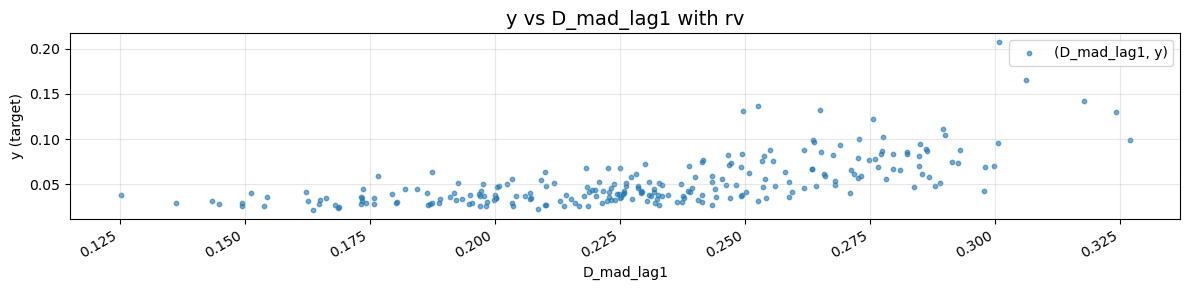

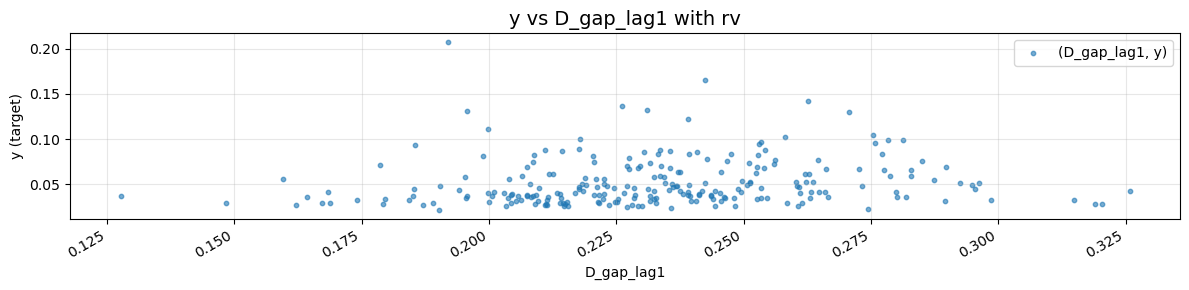

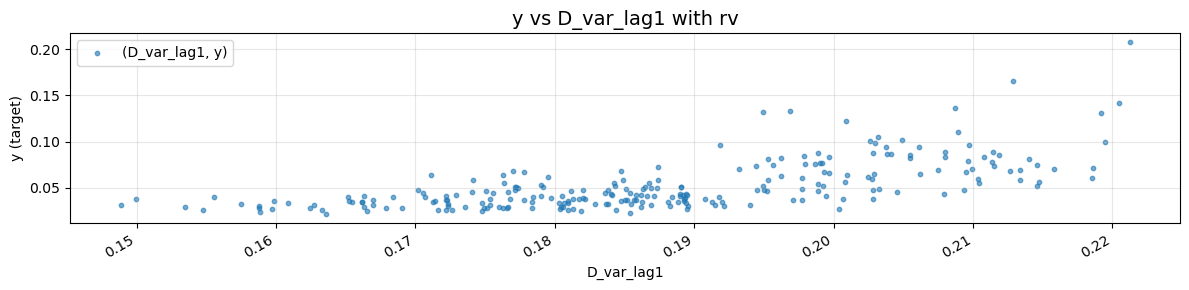

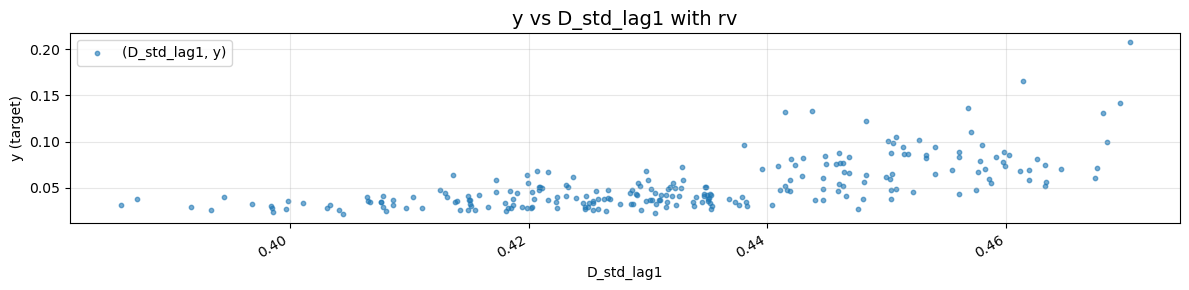

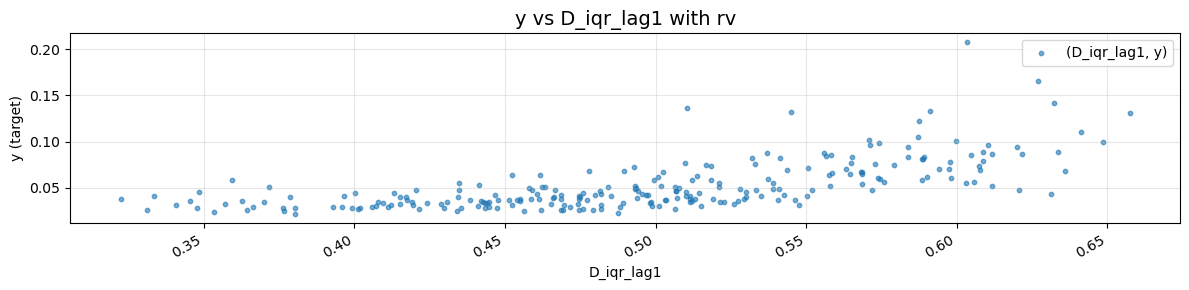

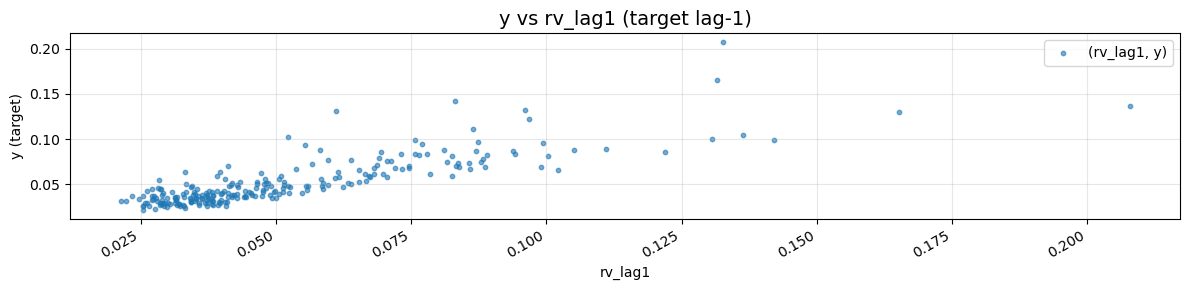

In [29]:
plot_model_feature_scatter(model_train_rv, base_target="rv")
# plot_model_feature_scatter(model_train_park, base_target="parkinson") 
# plot_model_feature_scatter(model_train_asbret, base_target="absret_daily")

### Plot the Model correlations
We can plot the correlation matrix to show the correlation value between each feature based on the target

In [50]:
def plot_model_correlations(model_train: pl.DataFrame, base_target: str = "rv"):
    """
    Correlation matrix between y and main predictors,
    visualized as a heatmap.
    """
    cols = ["y", "D_mad_lag1", "D_gap_lag1", "D_var_lag1", "D_std_lag1", "D_iqr_lag1", 
            "D_mad_7d", "D_gap_7d", "D_var_7d", "D_std_7d", "D_iqr_7d",
            f"{base_target}_lag1"]
    # keep only existing columns
    cols = [c for c in cols if c in model_train.columns]

    df = model_train.select(cols).to_pandas()
    corr = df.corr()

    plt.figure(figsize=(5, 4))
    im = plt.imshow(corr.values, interpolation="nearest", aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)

    plt.title("Correlation Matrix (Target & Predictors)", fontsize=14)
    plt.tight_layout()
    plt.show()

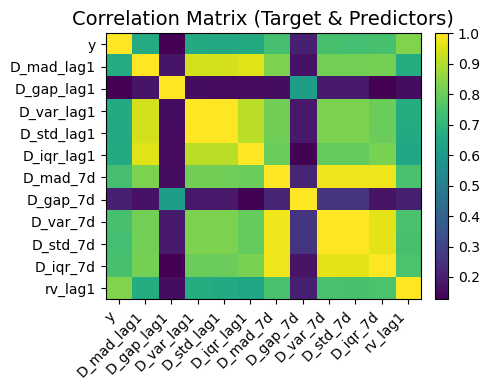

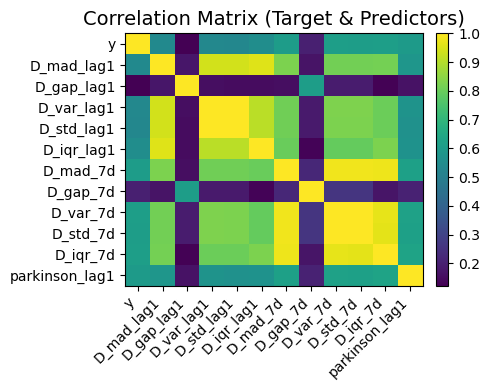

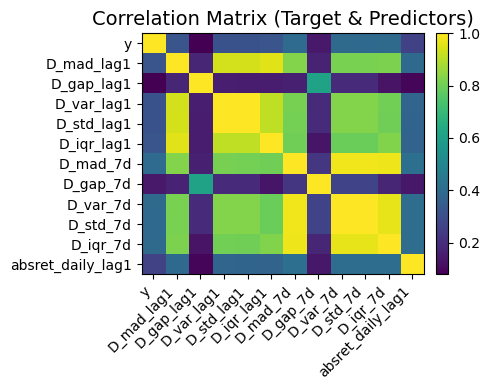

In [51]:
plot_model_correlations(model_train_rv, base_target="rv")
plot_model_correlations(model_train_park, base_target="parkinson") 
plot_model_correlations(model_train_asbret, base_target="absret_daily")

## Training Fase using the model and dataset
Now we can train our model using the previous datasets of sentiment disagreement, and price instability. 

### Helper functions
Some helper function we need to prepare for the training
- **part_bounds**: Splits the year 2018 into 6 equal time intervals and returns the start and end timestamps of the chosen part.
- **keep_full_days_inside**: Keeps only those dates whose entire 24-hour day lies fully inside the given time slice (no partial days).
- **model_combination**: builds a dictionary of regression model specifications.
Each key is a model name, and each value is the list of feature columns used in that model. The total number of model combinatos is 64.

In [32]:
def part_bounds(part: int):
    year_start = datetime(2018, 1, 1)
    year_end   = datetime(2019, 1, 1)
    step = (year_end - year_start) / 6
    slice_start = year_start + step * (part - 1)
    slice_end   = year_start + step * part
    return slice_start, slice_end

def keep_full_days_inside(df_daily: pl.DataFrame, slice_start, slice_end) -> pl.DataFrame:
    """
    Keep ONLY days where the entire [00:00, 24:00) interval is inside [slice_start, slice_end).
    This avoids "split day" leakage when part boundaries cut through a day.
    """
    return (
        df_daily
        .with_columns([
            pl.col("date").cast(pl.Datetime).alias("day_start"),
            (pl.col("date").cast(pl.Datetime) + pl.duration(days=1)).alias("day_end"),
        ])
        .filter((pl.col("day_start") >= slice_start) & (pl.col("day_end") <= slice_end))
        .drop(["day_start", "day_end"])
        .sort("date")
    )
    
def model_combination(ar_lag_col: str):
    """
    Build full model-spec dictionary using the correct AR(1) lag column.
    Example: ar_lag_col='rv_lag1', 'parkinson_lag1', or 'absret_daily_lag1'.
    """

    DISAGREE_FEATURES = [
        "D_mad_lag1",
        "D_gap_lag1",
        "D_var_lag1",
        "D_std_lag1",
        "D_iqr_lag1",
        "D_mad_7d",
        "D_gap_7d",
        "D_var_7d",
        "D_std_7d",
        "D_iqr_7d",
    ]

    # Build MODEL dictionary
    MODELS = {
        "Baseline_const": [],  # intercept-only model
    }

    # 1) Single disagreement features
    for f in DISAGREE_FEATURES:
        MODELS[f"D_only_{f.replace('_lag1','').upper()}"] = [f]

    # 2) All combinations of disagreement features (size ≥ 2)
    import itertools
    for k in range(2, len(DISAGREE_FEATURES) + 1):
        for combo in itertools.combinations(DISAGREE_FEATURES, k):
            name = "D_" + "_".join([c.replace("_lag1","").upper() for c in combo])
            MODELS[name] = list(combo)

    # 3) Baseline AR model
    MODELS["Baseline_AR1"] = [ar_lag_col]

    # 4) AR(1) + single disagreement feature
    for f in DISAGREE_FEATURES:
        MODELS[f"AR1_plus_{f.replace('_lag1','').upper()}"] = [ar_lag_col, f]

    # 5) AR(1) + all disagreement combos (≥2)
    for k in range(2, len(DISAGREE_FEATURES) + 1):
        for combo in itertools.combinations(DISAGREE_FEATURES, k):
            base_name = "_".join([c.replace("_lag1","").upper() for c in combo])
            MODELS[f"AR1_plus_{base_name}"] = [ar_lag_col] + list(combo)

    return MODELS


### Append parts 1-5 and prepare for training
- First merge the training and test datasets so the time series is continuous. This allows lag-1 features (yesterday’s values) to be computed correctly across the train to test boundary.
- Then compute daily sentiment features and daily BTC volatility, join them, add lagged features, and build the final modeling table
- compute the date ranges for training (parts 1–4) and validation (part 5), filter the modeling table to keep only full days inside those ranges,

In [33]:
# Combine raw data so lag(1) can cross the train->val boundary correctly
tweets_1to4 = data.load_data_sentiment("../data/tweets_training.csv")
tweets_5 = data.load_data_sentiment("../data/sentiment/tweets_5_sent.csv")
reddit_1to4 = data.load_data_sentiment("../data/reddit_training.csv")
reddit_5 = data.load_data_sentiment("../data/sentiment/reddit_5_sent.csv")
btc_1to4 = data.load_btc("../data/btc_training.csv")
btc_5 = data.load_btc("../data/btc_5.csv")


reddit_1to5 = pl.concat([reddit_1to4, reddit_5], how="vertical").sort("timestamp")
tweets_1to5 = pl.concat([tweets_1to4, tweets_5], how="vertical").sort("timestamp")
btc_1to5    = pl.concat([btc_1to4, btc_5], how="vertical").sort("timestamp")

# Daily sentiment features (D_mad, D_gap)
sent_1to5 = sentiment_disagreement_daily(reddit_1to5, tweets_1to5)

# Daily BTC instability from 1m bars (rv etc.)
btc_daily_1to5 = btc_daily_instability_from_1m(btc_1to5, require_full_day=True)

# Join + lag features; y = today's rv
model_1to5_rv = build_daily_model_df(btc_daily_1to5, sent_1to5, target_col="rv")
model_1to5_parkinson = build_daily_model_df(btc_daily_1to5, sent_1to5, target_col="parkinson")
model_1to5_absret = build_daily_model_df(btc_daily_1to5, sent_1to5, target_col="absret_daily")


print(model_1to5_rv.select(["date", "y", "D_mad_lag1", "D_gap_lag1", "D_var_lag1", 
                   "D_std_lag1", "D_iqr_lag1", "rv_lag1"]).head(2))

train_start, _        = part_bounds(1)
_, train_end          = part_bounds(4)
val_start, val_end    = part_bounds(5)

rv_train_df = keep_full_days_inside(model_1to5_rv, train_start, train_end)
rv_val_df   = keep_full_days_inside(model_1to5_rv, val_start, val_end)

park_train_df = keep_full_days_inside(model_1to5_parkinson, train_start, train_end)
park_val_df   = keep_full_days_inside(model_1to5_parkinson, val_start, val_end)

absret_train_df = keep_full_days_inside(model_1to5_absret, train_start, train_end)
absret_val_df   = keep_full_days_inside(model_1to5_absret, val_start, val_end)

print("train days:", rv_train_df.height)
print("val days:",   rv_val_df.height)


shape: (2, 8)
┌────────────┬──────────┬────────────┬────────────┬────────────┬────────────┬───────────┬──────────┐
│ date       ┆ y        ┆ D_mad_lag1 ┆ D_gap_lag1 ┆ D_var_lag1 ┆ D_std_lag1 ┆ D_iqr_lag ┆ rv_lag1  │
│ ---        ┆ ---      ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ 1         ┆ ---      │
│ date       ┆ f64      ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ ---       ┆ f64      │
│            ┆          ┆            ┆            ┆            ┆            ┆ f64       ┆          │
╞════════════╪══════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪══════════╡
│ 2018-01-02 ┆ 0.082483 ┆ 0.246582   ┆ 0.208879   ┆ 0.196258   ┆ 0.44301    ┆ 0.532059  ┆ 0.089043 │
│ 2018-01-03 ┆ 0.081656 ┆ 0.284859   ┆ 0.220438   ┆ 0.21399    ┆ 0.462591   ┆ 0.58873   ┆ 0.082483 │
└────────────┴──────────┴────────────┴────────────┴────────────┴────────────┴───────────┴──────────┘
train days: 242
val days: 60


### Error function
We define two simple error function: 
- **Root Mean Squared Error (RMSE)**: Computes the average sqaured prediction error, penalizes large errros more heavily and good for measuring overall prediction accuracy. Defined as:
$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^n (y_i-\hat{y_i})^2}$$
- **Mean Absolute Error**: Computes the average absolute prediction error, measures typical prediction error, less sensitive to outliers than RMSE. Defines as:
$$\text{MAE}=\frac{1}{n}\sum_{i=1}^n|y_i-\hat{y_i}|$$

In [34]:
def rmse(y, yhat): 
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def mae(y, yhat):  
    return float(np.mean(np.abs(y - yhat)))

### Model Training Pipeline
First we build the regression matrix, this is the standard way to represent all predictor variables in linear regression. This is also required because OLS solves a matrix equation:
$$\hat{\beta}=(X^{\top} X)^{-1} X^{\top} y$$
Then we fit an OLS regression on the training set and makes prediction on the validation set. The steps are:
1. Extract training and validation target arrays (y_traning_raw and y_validation_raw)
2. If log_y is True, then we model the data in log-space with $y=\log(y+10^{-12})$. The small $10^{-12}$ prevents $\log (0)$ errors
3. Build $X$ matrices for train and validation using design_matrix()
4. Fit the model using HAC (Newey–West) robust standard errors with maxlags=7.
5. Predict validation values in log scale.
6. Convert predictions back to raw scale if needed: $\hat{y}_{raw}=e^{\hat{y}}-10^{-12}$
7. Return fitted model, X column names, true and predicted values (log and raw)

The reason that we use HAC is that OLS assumptions are often violated in time-series, therefore underestimates uncertainty. In time series data like volatility, the errors are not independent:
- They are autocorrelated, for example todays residual depends on yesterday
- They may have heteroskedasticity, that variance changes over time.

HAC stands for Heteroskedasticity and Autocorrelation Consistent. It does not change the coefficient estimates, but it corrects the standard errors. So that, t-statistics, confidence interval, p-values are valid even when errors are correlated or heteroskedastic. The choice of maxlags=7 tells HAC to account for autocorrelation up to 7 lags of one week, which is reasonable for daily volatility. 

In [35]:
def design_matrix(df_pl, x_cols):
    """Return (X, names) with intercept."""
    n = df_pl.height
    if len(x_cols) == 0:
        return np.ones((n, 1)), ["const"]
    X = df_pl.select(x_cols).to_numpy()
    X = sm.add_constant(X, has_constant="add")
    return X, ["const"] + x_cols

def fit_predict(training_df, validation_df, x_cols, y_col="y", log_y=True, hac_lags=7):
    """Fit OLS on train, predict val. Returns result + arrays in log and raw scale."""
    y_training_raw = training_df[y_col].to_numpy()
    y_validation_raw = validation_df[y_col].to_numpy()

    if log_y:
        y_training = np.log(y_training_raw + 1e-12)
        y_validation = np.log(y_validation_raw + 1e-12)
    else:
        y_training = y_training_raw
        y_validation = y_validation_raw

    X_training, names = design_matrix(training_df, x_cols)
    X_validation, _ = design_matrix(validation_df, x_cols)

    res = sm.OLS(y_training, X_training).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    predit_validation = res.predict(X_validation)

    if log_y:
        predite_validation_raw = np.exp(predit_validation) - 1e-12
    else:
        predite_validation_raw = predit_validation

    return {
        "res": res,
        "names": names,
        "x_cols": x_cols,
        "y_validation": y_validation,
        "predit_validation": predit_validation,
        "y_validation_raw": y_validation_raw,
        "predit_validation_raw": predite_validation_raw,
    }

def training_model(training_df, validation_df, ar_lag_col):
    # Define your baseline + augmented specs 
    MODELS = model_combination(ar_lag_col)
    # Fit all models (train) and evaluate on validation 
    results = {}
    metrics = []
    
    for name, x_cols in MODELS.items():
        out = fit_predict(training_df, validation_df, x_cols, y_col="y", log_y=True, hac_lags=7)
        results[name] = out
        metrics.append({
            "model": name,
            "rmse_log": rmse(out["y_validation"], out["predit_validation"]),
            "mae_log": mae(out["y_validation"], out["predit_validation"]),
            "rmse_raw": rmse(out["y_validation_raw"], out["predit_validation_raw"]),
            "mae_raw": mae(out["y_validation_raw"], out["predit_validation_raw"]),
        })
    return metrics, results

With these function defined, we can now train the model and return the results in metrics

In [36]:
rv_metrics, rv_result = training_model(rv_train_df, rv_val_df, "rv_lag1")
park_metrics, park_result = training_model(park_train_df, park_val_df, "parkinson_lag1")
absret_metrics, absret_result = training_model(absret_train_df, absret_val_df, "absret_daily_lag1")

### Evaluation of the model performance
We can evaluate the model performance based on the returned matrics, and based four criterieas:
- RMSE (raw scale)
- RMSE (log scale)
- MAE (raw scale)
- MAE (log scale)

In [37]:
def report_best_models(metrics):
    """
    Print the best models for each evaluation metric and return a dict
    mapping metric-key -> best-model-name.
    """
    criteria = {
        "rmse_raw": "RMSE (raw scale)",
        "rmse_log": "RMSE (log scale)",
        "mae_raw":  "MAE  (raw scale)",
        "mae_log":  "MAE  (log scale)",
    }

    best_models = {}

    print("\n=== Best Models on Validation Set ===")
    for key, label in criteria.items():
        best = min(metrics, key=lambda d: d[key])
        best_models[key] = best["model"]
        print(f"{label:20} → {best['model']}  (value = {best[key]:.6f})")
    print("=====================================\n")

    return best_models


We evaluates the models based on the different targets. It indicates that the following models peform best based on certiain critarias:
- AR1_plus_D_MAD_D_GAP
- AR1_plus_D_GAP_D_IQR
- AR1_plus_D_GAP_D_VAR_D_STD_D_IQR
- AR1_plus_D_GAP_D_STD_D_IQR
- D_D_VAR_D_STD_D_IQR
- AR1_plus_D_MAD_D_GAP_D_STD_D_IQR
- D_D_MAD_D_GAP_D_VAR_D_STD_D_IQR

In [38]:
rv_best_models = report_best_models(rv_metrics)
park_best_models = report_best_models(park_metrics)
absret_best_models = report_best_models(absret_metrics)
print(rv_best_models)


=== Best Models on Validation Set ===
RMSE (raw scale)     → AR1_plus_D_GAP_D_MAD_7D_D_GAP_7D  (value = 0.010210)
RMSE (log scale)     → AR1_plus_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.444736)
MAE  (raw scale)     → AR1_plus_D_VAR_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.008572)
MAE  (log scale)     → AR1_plus_D_VAR_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.363641)


=== Best Models on Validation Set ===
RMSE (raw scale)     → AR1_plus_D_GAP_7D_D_IQR_7D  (value = 0.012844)
RMSE (log scale)     → AR1_plus_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.730727)
MAE  (raw scale)     → AR1_plus_D_VAR_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.010397)
MAE  (log scale)     → AR1_plus_D_VAR_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.604598)


=== Best Models on Validation Set ===
RMSE (raw scale)     → D_D_STD_D_IQR_7D  (value = 0.015464)
RMSE (log scale)     → D_D_MAD_D_STD_D_GAP_7D_D_IQR_7D  (value = 1.326897)
MAE  (raw scale)     → D_D_GAP_D_STD_D_IQR_D_MAD_7D_D_GAP_7D  (value = 0.010541)
MAE

### Plot Models vs Baseline
We can plot all the predictions from the best model comapre to the given baseline

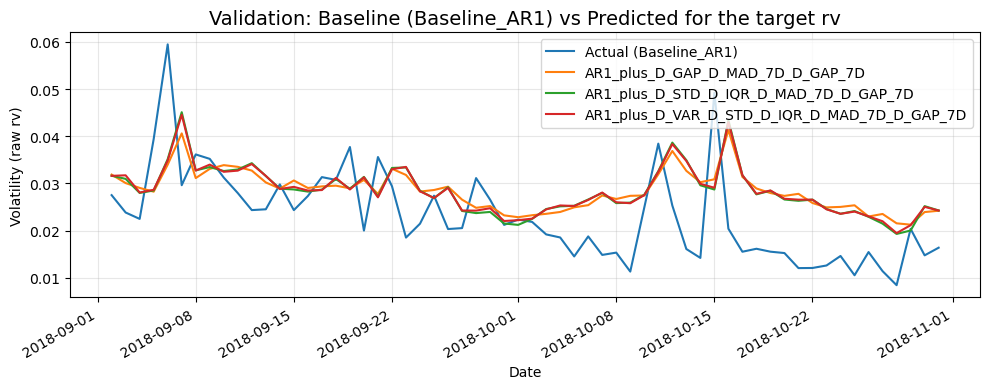

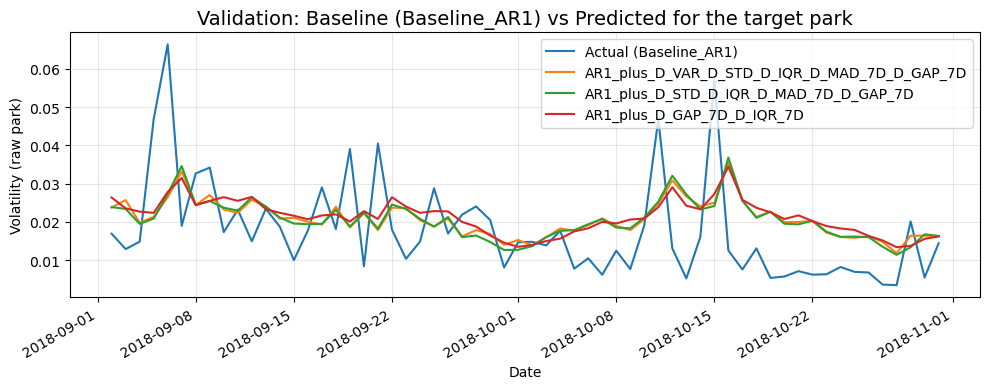

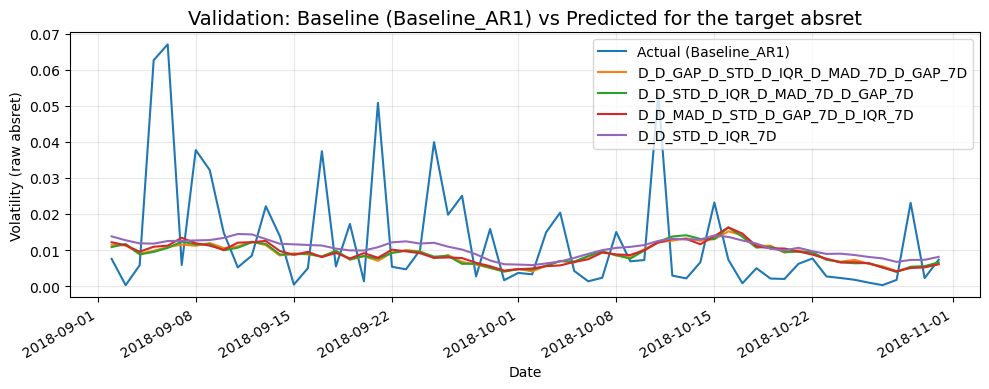

In [45]:
def plot_best_models_vs_baseline(
    validation_df: pl.DataFrame, 
    results: dict, 
    best_models: dict, 
    target: str,
    baseline_name="Baseline_AR1", 
    use_raw=True
):
    dates = validation_df["date"].to_list()
    if use_raw: 
        y = results[baseline_name]["y_validation_raw"]
        ylabel = f"Volatility (raw {target})"
    else:
        y = results[baseline_name]["y_validation"]
        ylabel = f"log(Volatility ({target}))"
        
    plt.figure(figsize=(10, 4))
    plt.plot(dates, y, label=f"Actual ({baseline_name})")
    
    unique_values = set(best_models.values())
    for item in unique_values:
        # print(item)
        # print(results[item])
        yhat = results[item]["predit_validation_raw"]
        plt.plot(dates, yhat, label=item)
        
    apply_common_style(
        title=f"Validation: Baseline ({baseline_name}) vs Predicted for the target {target}",
        xlabel="Date",
        ylabel=ylabel,
    )

plot_best_models_vs_baseline(rv_val_df, rv_result, rv_best_models, "rv")
plot_best_models_vs_baseline(park_val_df, park_result, park_best_models, "park")
plot_best_models_vs_baseline(absret_val_df, absret_result, absret_best_models, "absret")


### Hypothesis Test
Perfoms a hypothesis test on a single regression coefficient from the statistical model. It extracts:
- the coefficient value **beta**
- its t-statistic **t**
- and the standard two sided p-value **p2**, converst into one sided if needed.

Our hypothesis will then be:
- **Null Hypothesis** $H_0$: Sentiment disagreement is not associated and has no effect with Bitcoin price instability (volatility)
$$H_0:\beta=0$$
- **Alternative Hypothesis** $H_1$: Higher sentiment disagreement preditct higher Bitcoin price instability (volatility)
$$H_1:\beta>0$$

For this hypothesis test, we will take the model **AR1_plus_D_MAD_D_GAP** and **AR1_plus_D_GAP_D_IQR** for the target of RV, as is has the most signifficant results compare with other model. We will perform statistical test for each avalible coefficient used in these two models

In [40]:
def coef_test(res, names, term, alpha=0.05, alternative="greater"):
    """
    alternative:
      - "two-sided": H1 beta != 0
      - "greater"  : H1 beta > 0
      - "less"     : H1 beta < 0
    """
    idx = names.index(term)
    beta = float(res.params[idx])
    t = float(res.tvalues[idx])
    p2 = float(res.pvalues[idx])  # two-sided

    if alternative == "two-sided":
        p = p2
    elif alternative == "greater":
        p = (p2 / 2.0) if beta > 0 else (1.0 - p2 / 2.0)
        reject = p < alpha
    elif alternative == "less":
        p = (p2 / 2.0) if beta < 0 else (1.0 - p2 / 2.0)
        reject = p < alpha
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    return {"term": term, "beta": beta, "t": t, "p": float(p), "alpha": alpha, "reject_H0": bool(reject)}
    
# Example: test D_mad_lag1 in AR1_plus_MAD
chosen1 = rv_result["AR1_plus_D_MAD_D_GAP"]
out1_1 = coef_test(chosen1["res"], chosen1["names"], "D_mad_lag1", alpha=0.05, alternative="greater")
print(out1_1)
out1_2 = coef_test(chosen1["res"], chosen1["names"], "D_gap_lag1", alpha=0.05, alternative="greater")
print(out1_2)

chosen2 = rv_result["AR1_plus_D_GAP_D_IQR"]
out2_1 = coef_test(chosen2["res"], chosen2["names"], "D_gap_lag1", alpha=0.05, alternative="greater")
print(out2_1)
out2_2 = coef_test(chosen2["res"], chosen2["names"], "D_iqr_lag1", alpha=0.05, alternative="greater")
print(out2_2)



{'term': 'D_mad_lag1', 'beta': 3.192541494227756, 't': 4.771316969320934, 'p': 9.151262588361272e-07, 'alpha': 0.05, 'reject_H0': True}
{'term': 'D_gap_lag1', 'beta': 0.31687082230124775, 't': 0.7484119149994994, 'p': 0.22710586893017515, 'alpha': 0.05, 'reject_H0': False}
{'term': 'D_gap_lag1', 'beta': 0.39569342333185037, 't': 0.9542674848459985, 'p': 0.16997413116839183, 'alpha': 0.05, 'reject_H0': False}
{'term': 'D_iqr_lag1', 'beta': 1.7988014343516647, 't': 4.7738826389821964, 'p': 9.035385717803328e-07, 'alpha': 0.05, 'reject_H0': True}


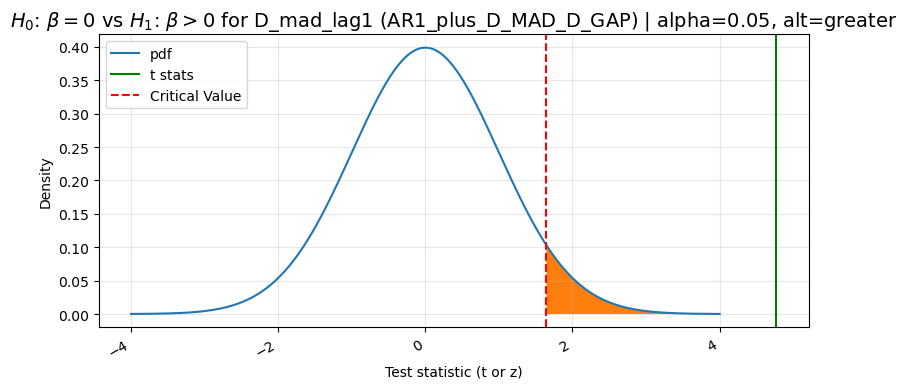

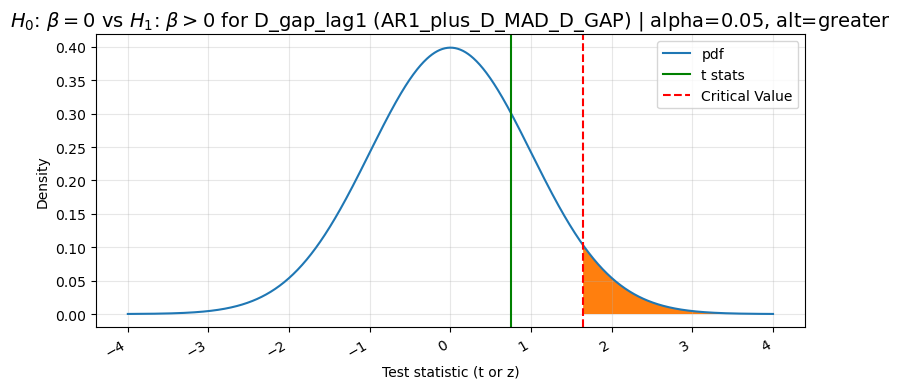

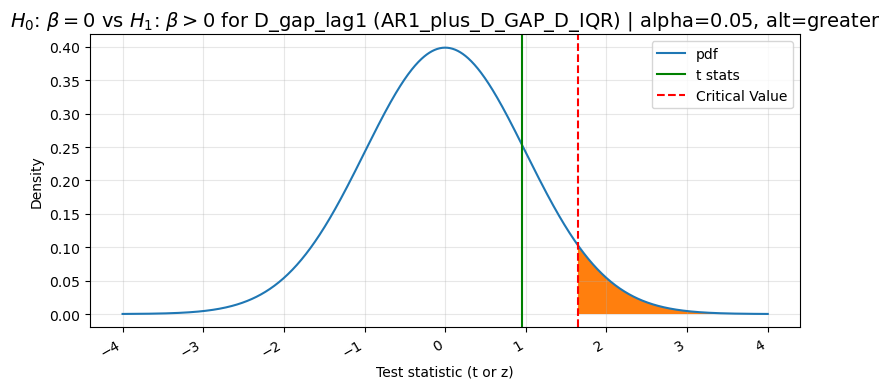

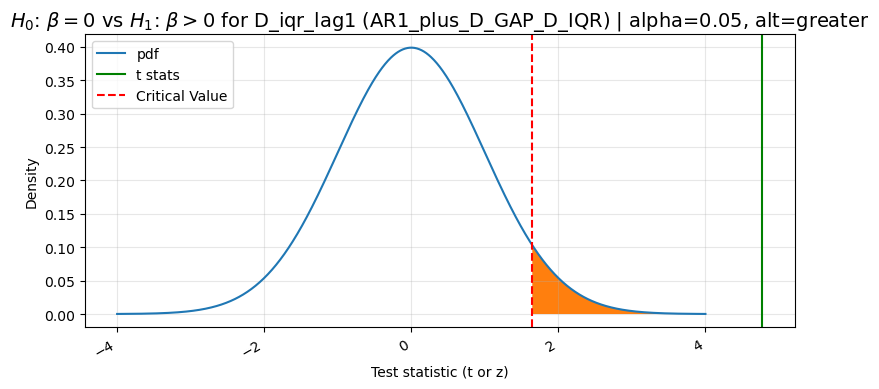

In [41]:
def plot_null_test_normal(t_stat, alpha=0.05, alternative="greater", title="Hypothesis test (normal approx)"):
    x = np.linspace(-4, 4, 1000)
    pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2)
    from scipy.stats import norm
    z_crit_two_tailed = norm.ppf(1 - alpha/2)
    z_crit_one_tailed = norm.ppf(1 - alpha)
    # critical values
    if alternative == "two-sided":
        crit = z_crit_two_tailed  
        reject_left = x <= -crit
        reject_right = x >= crit
    elif alternative == "greater":
        crit = z_crit_one_tailed
        reject_left = np.zeros_like(x, dtype=bool)
        reject_right = x >= crit
    elif alternative == "less":
        crit = z_crit_one_tailed
        reject_left = x <= -crit
        reject_right = np.zeros_like(x, dtype=bool)
    else:
        raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")

    plt.figure(figsize=(8, 4))
    plt.plot(x, pdf, label="pdf")
    plt.fill_between(x, 0, pdf, where=reject_left)
    plt.fill_between(x, 0, pdf, where=reject_right)
    plt.axvline(t_stat, color="green", label="t stats")
    plt.axvline(crit if alternative != "less" else -crit, linestyle="--", color="red", label="Critical Value")
    if alternative == "two-sided":
        plt.axvline(-crit, linestyle="--", color="red", label="Critical Value")
    
    apply_common_style(
        title=title + f" | alpha={alpha}, alt={alternative}",
        xlabel="Test statistic (t or z)",
        ylabel="Density",
    )

# Use the t-stat from the same coefficient test you ran
plot_null_test_normal(out1_1["t"], alpha=0.05, alternative="greater",
                      title=r"$H_0$: $\beta=0$ vs $H_1$: $\beta>0$ for D_mad_lag1 (AR1_plus_D_MAD_D_GAP)")
plot_null_test_normal(out1_2["t"], alpha=0.05, alternative="greater",
                      title=r"$H_0$: $\beta=0$ vs $H_1$: $\beta>0$ for D_gap_lag1 (AR1_plus_D_MAD_D_GAP)")
plot_null_test_normal(out2_1["t"], alpha=0.05, alternative="greater",
                      title=r"$H_0$: $\beta=0$ vs $H_1$: $\beta>0$ for D_gap_lag1 (AR1_plus_D_GAP_D_IQR)")
plot_null_test_normal(out2_2["t"], alpha=0.05, alternative="greater",
                      title=r"$H_0$: $\beta=0$ vs $H_1$: $\beta>0$ for D_iqr_lag1 (AR1_plus_D_GAP_D_IQR)")

## Reference
1. R, R. (2024, October 18). Median Absolute deviation (MAD): a robust measure of variability. https://www.linkedin.com/pulse/median-absolute-deviation-mad-robust-measure-rajathilagar-r-raj--tygpf/
2. Ao, X. (n.d.). Heteroskedasticity and autocorrelation consistent standard errors. https://www.hbs.edu/research-computing-services/Shared%20Documents/Training/hac.pdf
3. Zhu, A. (2025, January 20). Linear Regression with OLS: Heteroskedasticity and Autocorrelation. Towards Data Science. https://towardsdatascience.com/linear-regression-with-ols-heteroskedasticity-and-autocorrelation-c12f1f65c13/